## Imports

In [1]:
# import matplotlib
# matplotlib.use('Qt5Agg')  # Set the backend to a valid option like 'TkAgg'
import matplotlib.pyplot as plt
import os
# print(os.environ.get('MPLBACKEND'))
import numpy as np
from PIL import Image
import time
import pandas as pd

In [2]:
def abrirImagenesEscaladas( carpeta, escala=32 ):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            if file.endswith('DS_Store'):
                continue
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [3]:
# Data
if(True):
    img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/')
    img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/') # NO FUNCIONA :(
    img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/')
    img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/')

    data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)


In [4]:
def balancear_datos(imagenes_entrenamiento):

    img_train_sin_neumonia = imagenes_entrenamiento[0]
    img_train_neumonia =imagenes_entrenamiento[1]
    img_test_sin_neumonia =imagenes_entrenamiento[2]
    img_test_neumonia = imagenes_entrenamiento[3]

    # MAX NUMBER OF IMAGES
    n_train = min(len(img_train_sin_neumonia), len(img_train_neumonia))
    n_test = min(len(img_test_sin_neumonia), len(img_test_neumonia))

    # BALANCE
    img_train_sin_neumonia = img_train_sin_neumonia[:n_train]
    img_train_neumonia = img_train_neumonia[:n_train]
    img_test_sin_neumonia = img_test_sin_neumonia[:n_test]
    img_test_neumonia = img_test_neumonia[:n_test]

    
    return (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)

In [5]:
data = balancear_datos(data)

## Ejercicio 1

#### Derivadas Parciales

Derivada con respecto a $\mathbf{w}$:

$
\frac{\partial L}{\partial \mathbf{w}} = \sum_{i=1}^{N} \left( \left(1 + \tanh(\mathbf{w} \cdot \mathbf{i} + b)\right)^2 - d_i \right) \left(1 - \tanh^2(\mathbf{w} \cdot \mathbf{i} + b)\right) \mathbf{i}
$

Derivada con respecto a $b$:

$
\frac{\partial L}{\partial b} = \sum_{i=1}^{N} \left( \left(1 + \tanh(\mathbf{w} \cdot \mathbf{i} + b)\right)^2 - d_i \right) \left(1 - \tanh^2(\mathbf{w} \cdot \mathbf{i} + b)\right)
$



In [6]:
#funcion f
def F(i,w,b):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        probabolidad: 0 < p < 1: Probabilidad de que la imagen sea un 1 (Tiene neumonia)
    """
    tan = np.tanh(np.dot(w,i)+b)
    return (tan + 1)/2

In [7]:
# Derivada de L con respecto a W
def L_w(i,w,b,d):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Vector: Gradiente de la probabilidad con respecto a los pesos
    """
    # t0=tanh(b+W⊤⋅i)
    #return: (1−t0^2)⋅((1+t0)/2−d)⋅i
    
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d) * i

In [8]:
# Derivada de L con respecto a b
def L_b(i,w,b,d):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Float: Gradiente de la probabilidad con respecto al bias
    """
    #t0=tanh(b+W⊤⋅i)
    #(1−t0^2)⋅((1+t0)/2−d)   
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d)

## Ejercicio 2

Implementar el metodo de descenso por gradiente y optimizar los parametros de la funcion f para el conjunto de datos de entrenamiento. Para esto les recomendamos que trabajen con un subconjunto de los datos que tenga una cantidad parecida de imagenes con y sin neumonia

In [9]:
def descenso_gradiente(w,b,gradiente_w, gradiente_b, alpha):
    """_summary_

    Args:
        imagenes_entrenamiento (List): Lista de imagenes de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate

    Returns:
        Tuple: Pesos y bias actualizados

    """
    w = w - alpha * gradiente_w
    b = b - alpha * gradiente_b
    return w,b



## Ejercicio 3

Calcular el error cuadratico durante la optimizacion para el conjunto de entrenamiento y para el conjunto de testing. Generar las visualizaciones correspondientes.

In [24]:


def train(datos, alpha=0.005, epochs = 5,seed = 42,plot_graph=True):
    """_summary_

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
    # inicioamos con pesos aleatorios
    # set numpy seed
    

    datos_sin_neumonia = np.array(datos[0])
    datos_con_neumonia = np.array(datos[1])

    
    np.random.seed(seed)
    print(datos_sin_neumonia[0].shape[0])
    w = np.random.randn(datos_sin_neumonia[0].shape[0]) * 0.01
    b = np.random.randn(1)*0.01
    #  Separar datos en entrenamiento y validación
   
    len_data = len(datos_sin_neumonia)+len(datos_con_neumonia)
    print(f"Tamaño de data: {len_data}   Ratio de ambos: {len(datos_sin_neumonia)/len(datos_con_neumonia)}")
    
   
    errores = []
    error = 0
    
    for epoch in range(epochs):  
        
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
       
            
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # w,b = desenso_gradiente(w,b,gradiente_w,gradiente_b,label,alpha)
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
        
     
        print(f"\r{gradiente_b}",end='',) 
               
        # Promediar los gradientes acumulados
        gradiente_w /= (len_data)
        gradiente_b /= (len_data)
        
        # Actualización de los parámetros
        w, b = descenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
       
        # Almacenar el error cuadrático promedio para visualización
        errores.append(error/len_data)
        
        # Almacenar el error cuadrático  para visualización
        # errores.append(error)
  
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        
        # Mostrar el error de la epoch actual
        print(f"\r{error/len_data}",end='',)
    
    if plot_graph:
        plt.plot(errores)
        plt.xlabel('Epoch')
        plt.ylabel('Error Cuadrático')
        plt.title('Error Cuadrático durante el Entrenamiento')
        plt.show()

    return w,b

In [25]:
def test(w,b,datos):
    """ Devuelve el porcentaje de de imagenes correctas que clasifico la funcion encontrada
    
    Args:
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 

    Returns:
        Float: Accuracy
    """
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    correctos = 0
    
    for i in datos_sin_neumonia:
        if F(i,w,b) < 0.5:
            correctos += 1
            
    for i in datos_con_neumonia:
        if F(i,w,b) >= 0.5:
            correctos += 1
            
    return correctos/(len(datos_sin_neumonia)+len(datos_con_neumonia))

1024
Tamaño de data: 2698   Ratio de ambos: 1.0
[0.15522437]]]]

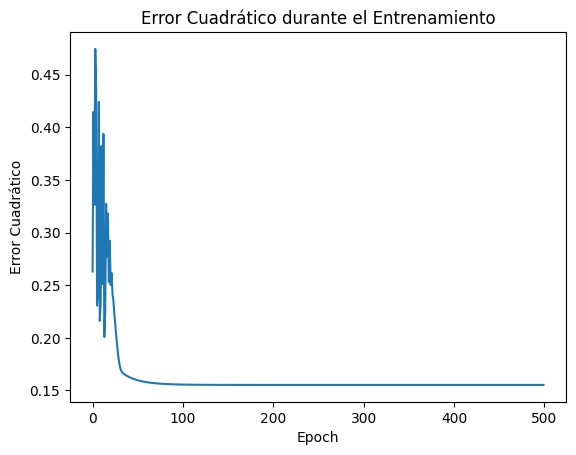

0.8595255744996294

In [26]:
train_sin, train_con, test_sin, test_con = data
training_data = (train_sin,train_con)
testing_data = (test_sin,test_con)

w_res, b_res = train(
    training_data,
    alpha=0.05,
    epochs = 500,
    seed = 42,
    plot_graph=True
    )

test(w_res,b_res,training_data)

In [35]:
error = 0
len_data = len(testing_data)      
            
# Entrenamiento con imágenes sin neumonía
label = 0
for i in testing_data[0]: 
    error += (F(i,w_res, b_res) - label)**2 # Falta arreglar esto


label = 1
for i in testing_data[1]:
    error += (F(i,w_res, b_res) - label)**2 # Falta arreglar esto
    
print(error/len_data)

test(w_res,b_res,testing_data)

[60.86015698]


0.5

## Ejercicio 4
Analizar el impacto del parametro α en la convergencia del metodo. Tomar un rango
de 5 valores posibles y analizar la convergencia para el conjunto de testing para los distintos valores de α.

In [13]:
def analizar_convergencia(errores):
    if len(errores) < 2:
        return float('inf') 
    return abs(errores[-1] - errores[-2]) / errores[-2]

In [27]:
def train_test_convergencia(datos, alpha,seed,diferencia_minima, plot_graph=True):
    """_summary_

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
    # inicioamos con pesos aleatorios
    # set numpy seed
    

    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    

    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0]) * 0.01
    b = np.random.randn(1)*0.01
    
    len_data = len(datos_sin_neumonia)+len(datos_con_neumonia)
     
  
    errores = []
    contador = 0
    while(True):  
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
       
            
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # w,b = desenso_gradiente(w,b,gradiente_w,gradiente_b,label,alpha)
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
        
     
        print(f"\r{gradiente_b}",end='',) 
               
        # Promediar los gradientes acumulados
        gradiente_w /= (len_data)
        gradiente_b /= (len_data)
        
        # Actualización de los parámetros
        w, b = descenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
        # Almacenar el error cuadrático promedio para visualización
        errores.append(error/len_data)
        
        diferencia = analizar_convergencia(errores)
        
        # Mostrar el error de la epoch actual
        print(f"\rError: {errores[-1]}  Diferencia: {diferencia}",end='',)
        
        if diferencia < diferencia_minima:
            print(f"Convergio en el epoch: {contador} con aplha: {alpha}")
            break
        
        contador += 1
       
        
    if plot_graph:
        plt.plot(errores)
        plt.xlabel('Epoch')
        plt.ylabel('Error Cuadrático')
        plt.title('Error Cuadrático durante el Entrenamiento')
        plt.show()

    return w,b,contador,alpha

Error: [0.04308371]  Diferencia: [9.99869433e-05]Convergio en el epoch: 1883 con aplha: 0.05


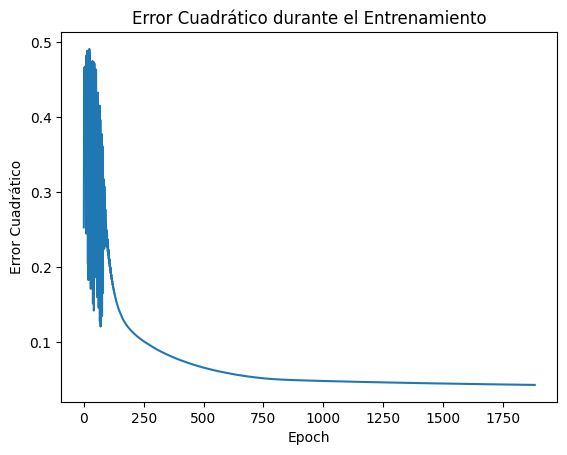

Error: [0.05676251]  Diferencia: [9.99781353e-05]Convergio en el epoch: 2410 con aplha: 0.01


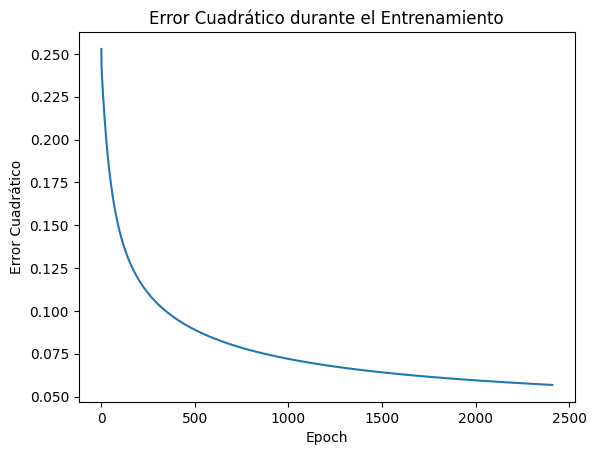

Error: [0.06549735]  Diferencia: [9.99860686e-05]Convergio en el epoch: 2776 con aplha: 0.005


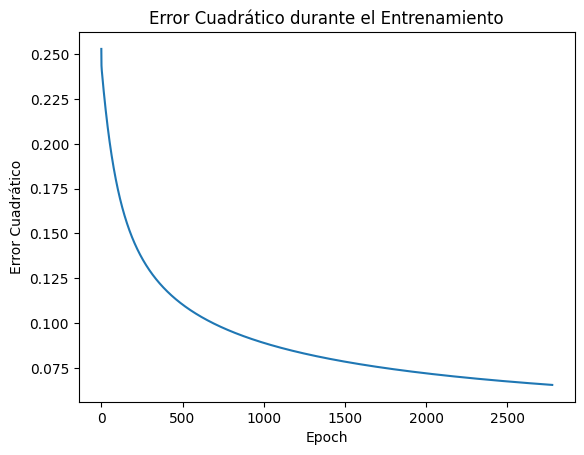

Error: [0.10318617]  Diferencia: [9.99705106e-05]Convergio en el epoch: 3106 con aplha: 0.001


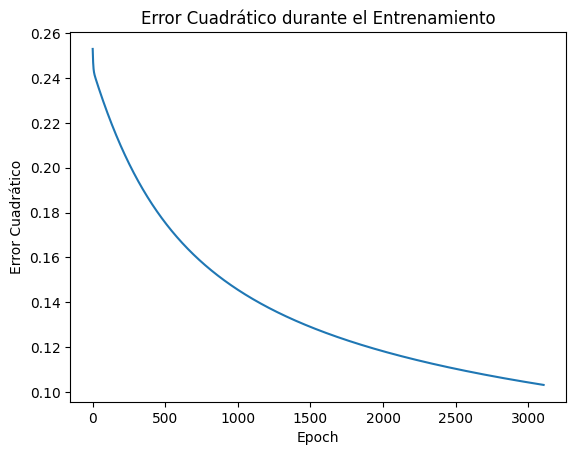

Error: [0.21556457]  Diferencia: [0.00036509]

KeyboardInterrupt: 

In [36]:

alphas = [ 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
tiempo_ejecucion = []
epochs = []
alphas_nuevos_valores = []
porcentaje_correctitud = []

diferencia_min = 1e-4

for i in alphas:
    
    start_time = time.time()
    
    w_res, b_res, epoch, alpha = train_test_convergencia(
        training_data,
        alpha=i,
        seed = 40,
        diferencia_minima = diferencia_min,
        plot_graph=True
        )
    
    end_time = time.time()
    
    tiempo_ejecucion.append(end_time - start_time)
    epochs.append(epoch)
    alphas_nuevos_valores.append(alpha)
    porcentaje_correctitud.append(test(w_res,b_res,(test_sin,test_con)))
    

In [30]:
# Crear un DataFrame con los datos

data = {
    'Metric': ['tiempo_ejecucion', 'alphas_nuevos_valores'],
    **{alpha: [tiempo_ejecucion[i], alphas_nuevos_valores[i]] for i, alpha in enumerate(alphas)}
}

df = pd.DataFrame(data)

# Nombre del archivo con el valor de convergencia en el título
filename = f'results_convergence_{diferencia_min:.0e}.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(filename, index=False)

print(f'Data saved to {filename}')

Data saved to results_convergence_1e-03.csv


## Graficos

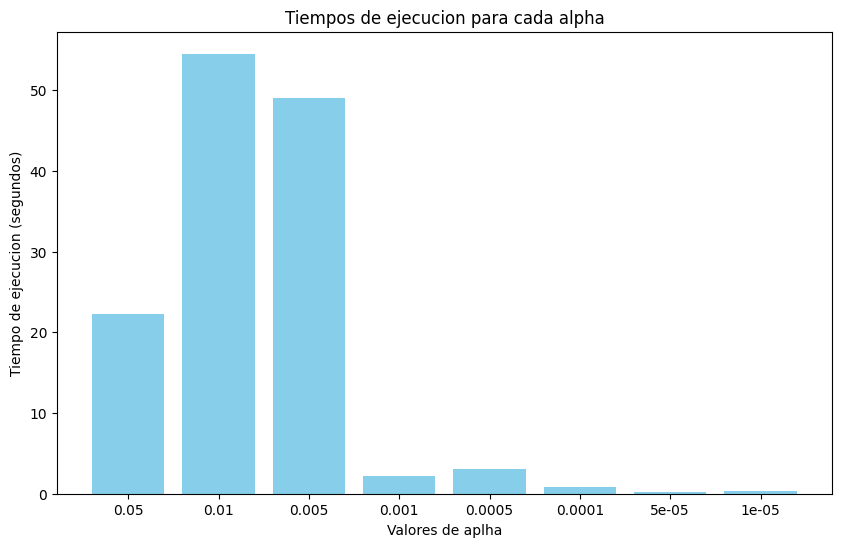

In [31]:
#Tiempos de ejecucion para cada alpha
plt.figure(figsize=(10, 6))

alphas_str = [str(alpha) for alpha in alphas]

plt.bar(alphas_str, tiempo_ejecucion, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Tiempo de ejecucion (segundos)')
plt.title('Tiempos de ejecucion para cada alpha')

plt.show()

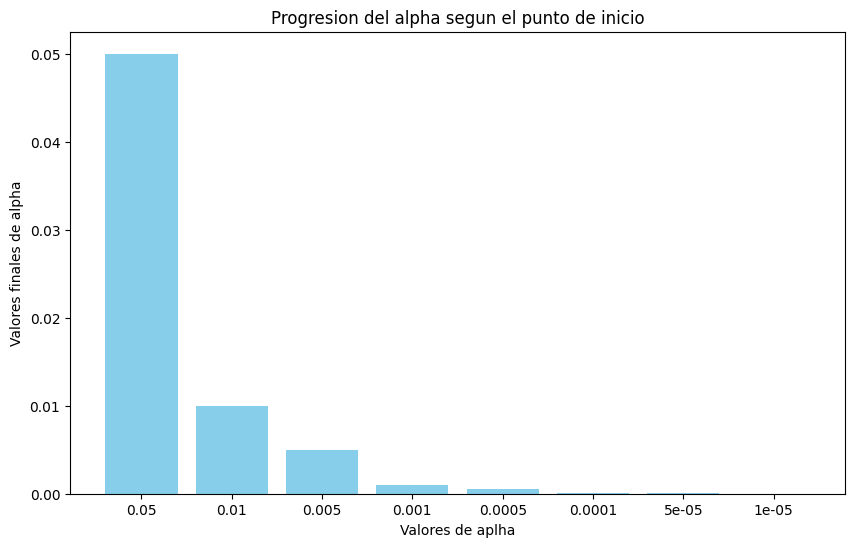

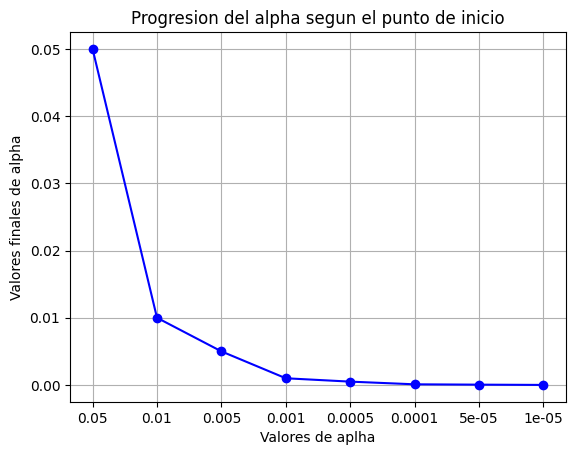

In [32]:
#Progresion del alpha segun el punto de inicio
plt.figure(figsize=(10, 6))

plt.bar(alphas_str, alphas_nuevos_valores, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Valores finales de alpha')
plt.title('Progresion del alpha segun el punto de inicio')

plt.show()

plt.plot(alphas_str, alphas_nuevos_valores, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Valores finales de alpha')
plt.title('Progresion del alpha segun el punto de inicio')

plt.grid(True) 
plt.show()

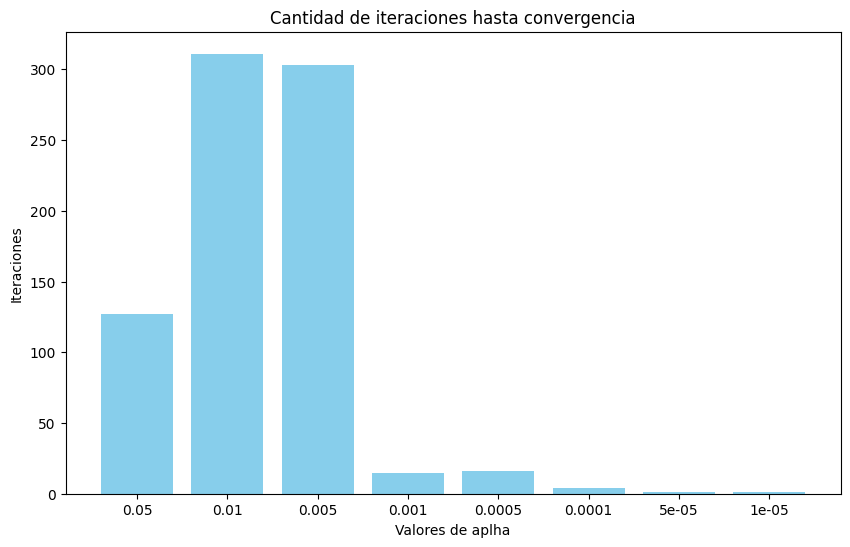

In [33]:
#Cantidad de iteraciones hasta convergencia
plt.figure(figsize=(10, 6))
plt.bar(alphas_str, epochs, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Iteraciones')
plt.title('Cantidad de iteraciones hasta convergencia')

plt.show()

El mejor valor de alpha es 0.001 ya que este genera el nuevo valor de alpha mas chico en la menor cantidad de tiempo

## Ejercicio 5

¿Como impacta el tamaño del escalado de las imagenes en la efectividad del metodo? ¿Y en el tiempo de computo?. Realizar los experimentos y graficos acordes para estudiar estas limitaciones.

In [ ]:
# Data
esclados = [32,64,128]
tiempo_ejecucion_esclado = []
efectividad = []

for i in esclados:
    img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/',i)
    img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/',i) 
    img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/',i)
    img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/',i)

    data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)
    
    data = balancear_datos(data)
    
    start_time = time.time()
    w_res, b_res = train(
        (train_sin, train_con),
        alpha=i,
        epochs=1500,
        seed = 42
        )
    end_time = time.time()
    tiempo_ejecucion_esclado.append(end_time - start_time)
    
    efectividad.append(test(w_res,b_res,(test_sin,test_con)))
    
    

## Graficos

In [ ]:
#Tiempos de ejecucion para cada esclado
plt.figure(figsize=(10, 6))

plt.plot(esclados, tiempo_ejecucion_esclado, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Tiempo de ejecucion (segundos)')
plt.title('Tiempos de ejecucion para cada esclado')
plt.legend()  
plt.grid(True) 
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(esclados, efectividad, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad de analisis segun diferentes escalados de imagen')
plt.legend()  
plt.grid(True) 
plt.show()

## Ejercicio 6 

Para el valor de α que tenga mejor valor de convergencia, generar la matriz de confusion y analizar brevemente la efectividad del metodo.

In [ ]:
def matriz_de_confusion(datos, w, b):
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    len_datos = len(datos)
    
    Verdadero_Positivo = 0
    Falso_Negativo = 0
    Verdadero_Negativo = 0
    Falso_Positivo = 0
    
    for i in datos_sin_neumonia:
        if F(i,w,b) < 0.5:
            Verdadero_Negativo += 1
        else:
            Falso_Positivo += 1
            
    for i in datos_con_neumonia:
        if F(i,w,b) >= 0.5:
            Verdadero_Positivo += 1
        else:
            Falso_Negativo += 1
            
    matriz = [[Verdadero_Positivo/len_datos,Falso_Negativo/len_datos],
              [Verdadero_Negativo/len_datos,Falso_Positivo/len_datos]]
    
    return matriz
    